In [1]:
import secrets
import pandas as pd
import numpy as np
#import seaborn as sns

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

from abc import ABC, abstractmethod
from dataclasses import dataclass

#sns.set(style="whitegrid")

In [2]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [3]:
import model.basic_model as basic_model
from model.stochastic_processes import (
    create_stochastic_process,
    plot_price,
)
from model.parts.init_stake import fetch_stake_data
from model.agents import (
    CEXAgent, LSTAgent, LRTAgent, SoloAgent, StakingPoolAgent, ETFAgent,
    StandardDeposit, StandardFullWithdraw
)
import model.agents_decision as agents_decision
import model.infra_costs as infra_costs
import model.APY as APY

from config import TIMESTEPS

/Users/amber/Desktop/Simulation/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# types
Run = int
Timestep = TIMESTEPS

# Price Traj Generation

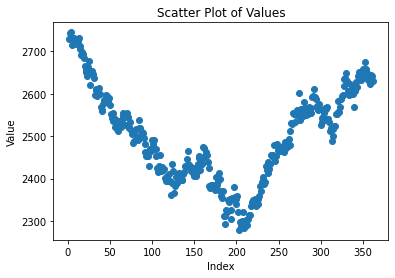

2278.6599203135465


In [5]:
eth_price_samples = create_stochastic_process(timesteps=Timestep,price_traj_type = 'concave')
eth_price_samples = [i for i in eth_price_samples] # ETH-USD pair
plot_price(eth_price_samples) 
print(min(eth_price_samples))

# Setup

In [6]:
constants = {
}

In [7]:
recent_staked = fetch_stake_data()
curr_stake_LRT = recent_staked[recent_staked['entity_category']=='Liquid Restaking']['amount_staked']
curr_stake_LST = recent_staked[recent_staked['entity_category']=='Liquid Staking']['amount_staked']
curr_stake_CEX = recent_staked[recent_staked['entity_category']=='CEXs']['amount_staked']
curr_stake_Solo = recent_staked[recent_staked['entity_category']=='Solo Stakers']['amount_staked']
curr_stake_SP = recent_staked[recent_staked['entity_category']=='Staking Pools']['amount_staked']
curr_stake_Unidentified = recent_staked[recent_staked['entity_category']=='Unidentified']['amount_staked']

In [8]:
recent_staked

,entity_category,amount_staked
0,CEXs,8.428639e+06
1,Liquid Restaking,2.831248e+06
2,Liquid Staking,1.106258e+07
3,Solo Stakers,3.402329e+05
4,Staking Pools,5.903047e+06
5,Unidentified,6.280785e+06


In [9]:
# Initialize an agent
cex_agent = CEXAgent(
    balance=curr_stake_CEX, 
    cnt=int(curr_stake_CEX/32), 
    category="CEX", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

lst_agent = LSTAgent(
    balance=curr_stake_LST, 
    cnt=int(curr_stake_LST/32), 
    category="LST", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

lrt_agent = LRTAgent(
    balance=curr_stake_LRT, 
    cnt=int(curr_stake_LRT/32), 
    category="LRT", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

solo_agent = SoloAgent(
    balance=curr_stake_Solo, 
    cnt=int(curr_stake_Solo/32), 
    category="Solo", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

sp_agent = StakingPoolAgent(
    balance=curr_stake_SP, 
    cnt=int(curr_stake_SP/32), 
    category="SP", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

etf_agent = ETFAgent(
    balance=0, 
    cnt=int(curr_stake_SP/32), 
    category="SP", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

<ipython-input-9-f3800099faa3>:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_CEX/32),
<ipython-input-9-f3800099faa3>:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_LST/32),
<ipython-input-9-f3800099faa3>:28: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_LRT/32),
<ipython-input-9-f3800099faa3>:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_Solo/32),
<ipython-input-9-f3800099faa3>:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(

# Simulation

In [10]:
ETH_initial_price = eth_price_samples[0]
agents = {
        "CEXAgent": cex_agent,
        "LSTAgent": lst_agent,
        "LRTAgent": lrt_agent,
        "SoloAgent": solo_agent,
        "StakingPoolAgent": sp_agent,
    }

In [11]:
@dataclass
class MVIParams:

    eth_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: eth_price_samples[timestep]]
    )

    opportunity_cost: List[float] = default([0.02])

    revenue_baseline_reduction: List[float] = default([0.005])
    mev_and_priority_add: List[float] = default([0.005])
    revenue_adjustment_beta: List[float] = default([1.0])

parameters = MVIParams().__dict__

In [12]:
psub = [{
    "policies": {
    },
    "variables": {
        "timestep": basic_model.update_timestep,
        "price": basic_model.update_price,
    }
},  { 
    "policies": {
        "action": agents_decision.deposit_withdraw
    },
    "variables": {
        "CEXAgent": agents_decision.update_CEXAgent_deposit_withdraw,
        "LSTAgent": agents_decision.update_LSTAgent_deposit_withdraw,
        "LRTAgent": agents_decision.update_LRTAgent_deposit_withdraw,
        "SoloAgent": agents_decision.update_SoloAgent_deposit_withdraw,
        "StakingPoolAgent": agents_decision.update_StakingPoolAgent_deposit_withdraw,
    }
},  { # TODO: double check the infra costs
    "policies": { 
        "action": infra_costs.calc_costs
    },
    "variables": {
        "CEXAgent": infra_costs.update_CEXAgent_cost,
        "LSTAgent": infra_costs.update_LSTAgent_cost,
        "LRTAgent": infra_costs.update_LRTAgent_cost,
        "SoloAgent": infra_costs.update_SoloAgent_cost,
        "StakingPoolAgent": infra_costs.update_StakingPoolAgent_cost,
    }
},  { 
    "policies": {
        "action": APY.calc_decentralization_and_total_staked
    },
    "variables": {
        "total_staked": APY.update_total_staked,
        "total_validator_cnt": APY.update_total_validator_cnt,
        "decentralization_metrics": APY.update_decentralization_metrics,
    }
}, { 
    "policies": {
        "action": APY.calc_issuance_APR
    },
    "variables": {
        "issuance_APR": APY.update_issuance_APR
    }
}, { 
    "policies": {
        "action": APY.calc_revenue_APY
    },
    "variables": {
        "revenue_APY": APY.update_revenue_APY,
        "revenue_APY_at_agent": APY.update_revenue_APY_at_agent
    }
}
]

initial_conditions = {
    "timestep": 0,
    "price": ETH_initial_price, 
    "CEXAgent": cex_agent,
    "LSTAgent": lst_agent,
    "LRTAgent": lrt_agent,
    "SoloAgent": solo_agent,
    "StakingPoolAgent": sp_agent,
    "ETFAgent": etf_agent,
    "total_staked": 0,
    "total_validator_cnt": 0,
    "decentralization_metrics": {},
    "issuance_APR": 0.0,
    "revenue_APY": 0.0,
    "revenue_APY_at_agent": {
        "CEXAgent": 0.0,
        "LSTAgent": 0.0,
        "LRTAgent": 0.0,
        "SoloAgent": 0.0,
        "StakingPoolAgent": 0.0
        }
}


params = parameters

model = Model(
        initial_state=initial_conditions,
        state_update_blocks=psub,
        params=params,
    )

In [13]:
simulation = Simulation(model=model, timesteps=Timestep, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
results = experiment.run()
df = pd.DataFrame(results)

2024-10-29 17:47:07,328 INFO root Starting simulation 0 / run 0 / subset 0


In [14]:
df

,timestep,price,CEXAgent,LSTAgent,LRTAgent,SoloAgent,StakingPoolAgent,ETFAgent,total_staked,total_validator_cnt,decentralization_metrics,issuance_APR,revenue_APY,revenue_APY_at_agent,simulation,subset,run,substep
0,0,2729.738442,CEXAgent(balance=0 8.428639e+06\nName: amou...,LSTAgent(balance=2 1.106258e+07\nName: amou...,LRTAgent(balance=1 2.831248e+06\nName: amou...,SoloAgent(balance=3 340232.899814\nName: am...,StakingPoolAgent(balance=4 5.903047e+06\nNa...,"ETFAgent(balance=0, cnt=184470, category='SP',...",0.000000e+00,0.000000e+00,{},0.000000,0.000000,"{'CEXAgent': 0.0, 'LSTAgent': 0.0, 'LRTAgent':...",0,0,1,0
1,1,2729.738442,CEXAgent(balance=0 8.428639e+06\nName: amou...,LSTAgent(balance=2 1.106258e+07\nName: amou...,LRTAgent(balance=1 2.831248e+06\nName: amou...,SoloAgent(balance=3 340232.899814\nName: am...,StakingPoolAgent(balance=4 5.903047e+06\nNa...,"ETFAgent(balance=0, cnt=184470, category='SP',...",0.000000e+00,0.000000e+00,{},0.000000,0.000000,"{'CEXAgent': 0.0, 'LSTAgent': 0.0, 'LRTAgent':...",0,0,1,1
2,1,2729.738442,CEXAgent(balance=0 8.431593e+06\nName: amou...,LSTAgent(balance=2 1.106480e+07\nName: amou...,LRTAgent(balance=1 2.831248e+06\nName: amou...,SoloAgent(balance=3 340232.899814\nName: am...,StakingPoolAgent(balance=4 5.906849e+06\nNa...,"ETFAgent(balance=0, cnt=184470, category='SP',...",0.000000e+00,0.000000e+00,{},0.000000,0.000000,"{'CEXAgent': 0.0, 'LSTAgent': 0.0, 'LRTAgent':...",0,0,1,2
3,1,2729.738442,CEXAgent(balance=0 8.431593e+06\nName: amou...,LSTAgent(balance=2 1.106480e+07\nName: amou...,LRTAgent(balance=1 2.831248e+06\nName: amou...,SoloAgent(balance=3 340232.899814\nName: am...,StakingPoolAgent(balance=4 5.906849e+06\nNa...,"ETFAgent(balance=0, cnt=184470, category='SP',...",0.000000e+00,0.000000e+00,{},0.000000,0.000000,"{'CEXAgent': 0.0, 'LSTAgent': 0.0, 'LRTAgent':...",0,0,1,3
4,1,2729.738442,CEXAgent(balance=0 8.431593e+06\nName: amou...,LSTAgent(balance=2 1.106480e+07\nName: amou...,LRTAgent(balance=1 2.831248e+06\nName: amou...,SoloAgent(balance=3 340232.899814\nName: am...,StakingPoolAgent(balance=4 5.906849e+06\nNa...,"ETFAgent(balance=0, cnt=184470, category='SP',...",3.447768e+07,1.077427e+06,"{'HHI': 0.22830529232136446, 'CR_k': 0.7368008...",0.000000,0.000000,"{'CEXAgent': 0.0, 'LSTAgent': 0.0, 'LRTAgent':...",0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,360,2632.759218,CEXAgent(balance=0 9.504299e+06\nName: amou...,LSTAgent(balance=2 1.187803e+07\nName: amou...,LRTAgent(balance=1 3.614135e+06\nName: amou...,SoloAgent(balance=3 351215.271992\nName: am...,StakingPoolAgent(balance=4 7.477233e+06\nNa...,"ETFAgent(balance=0, cnt=184470, category='SP',...",3.871681e+07,1.209900e+06,"{'HHI': 0.2236039393870794, 'CR_k': 0.74517867...",0.026730,0.017188,"{'CEXAgent': 0.018138287509741682, 'LSTAgent':...",0,0,1,2
2157,360,2632.759218,CEXAgent(balance=0 9.504299e+06\nName: amou...,LSTAgent(balance=2 1.187803e+07\nName: amou...,LRTAgent(balance=1 3.614135e+06\nName: amou...,SoloAgent(balance=3 351215.271992\nName: am...,StakingPoolAgent(balance=4 7.477233e+06\nNa...,"ETFAgent(balance=0, cnt=184470, category='SP',...",3.871681e+07,1.209900e+06,"{'HHI': 0.2236039393870794, 'CR_k': 0.74517867...",0.026730,0.017188,"{'CEXAgent': 0.018138287509741682, 'LSTAgent':...",0,0,1,3
2158,360,2632.759218,CEXAgent(balance=0 9.504299e+06\nName: amou...,LSTAgent(balance=2 1.187803e+07\nName: amou...,LRTAgent(balance=1 3.614135e+06\nName: amou...,SoloAgent(balance=3 351215.271992\nName: am...,StakingPoolAgent(balance=4 7.477233e+06\nNa...,"ETFAgent(balance=0, cnt=184470, category='SP',...",3.872786e+07,1.210246e+06,"{'HHI': 0.2235947884828462, 'CR_k': 0.74518691...",0.026730,0.017188,"{'CEXAgent': 0.018138287509741682, 'LSTAgent':...",0,0,1,4
2159,360,2632.759218,CEXAgent(balance=0 9.504299e+06\nName: amou...,LSTAgent(balance=2 1.187803e+07\nName: amou...,LRTAgent(balance=1 3.614135e+06\nName: amou...,SoloAgent(balance=3 351215.271992\nName: am...,StakingPool

In [15]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
    0: "normal",
}
)

In [16]:
visualizations.plot_total_staked(
    df,
    scenario_names={
    0: "normal",
}
)

In [17]:
visualizations.plot_hhi(
    df,
    scenario_names={
    0: "normal",
}
)

In [18]:
visualizations.plot_cost_APY_for_agents(df, ['StakingPoolAgent', 'SoloAgent'])


In [19]:
visualizations.plot_revenue_APY_for_agents(df, agents)

     timestep  CEXAgent  LSTAgent  LRTAgent  SoloAgent  StakingPoolAgent
0           2  1.932460  2.387652  2.172795   2.074267          2.126581
1           3  1.932029  2.387109  2.172320   2.074831          2.127711
2           4  1.931794  2.386728  2.171992   2.074671          2.127742
3           5  1.931379  2.386197  2.171526   2.071180          2.123154
4           6  1.930969  2.385672  2.171081   2.071947          2.124549
..        ...       ...       ...       ...        ...               ...
354       356  1.814702  2.232930  2.040671   1.905564          1.976077
355       357  1.814380  2.232512  2.040310   1.905816          1.976648
356       358  1.814111  2.232161  2.040003   1.903730          1.973894
357       359  1.813829  2.231784  2.039680   1.905524          1.976614
358       360  1.813544  2.231416  2.039371   1.903965          1.974612

[359 rows x 6 columns]


In [20]:
visualizations.plot_balance_for_agents(df, agents)

In [21]:
visualizations.plot_avg_revenue_APY(
    df,
    scenario_names={
    0: "normal",
}
)